<a href="https://colab.research.google.com/github/MukeshMishraReloaded/projects/blob/main/AdEase_timeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ad Ease

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

#Data Dictionary:

There are two csv files given:

#train_1.csv:
In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

The page name contains data in this format:

SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN

having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)

#Exog_Campaign_eng:

This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

There's 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

#Concepts Tested:

1) Exploratory data analysis

2) Time Series forecasting- ARIMA, SARIMAX, and Prophet.

3) What does “good” look like?

4) Importing the dataset and doing usual exploratory analysis steps like checking the structure & characteristics of the dataset

5) Checking null values and understanding their reason.

6) Understanding the page name format and splitting it to get different information.

7) Separating different values from it like title, language, access type, and access origin.

8) Visualizing the data and getting inferences from them. Converting the data to a format that can be fed to the Arima model (Pivoting etc)

9) Checking if the data is stationary - Dickey-Fuller test

10) Trying different methods for stationarity.

11) Decomposition of series.

12) Differencing the series.

13) Plotting the ACF and PACF plots

14) Give insights about the characteristics of the time series.

15) Modeling

16) Creating and training the Arima model

17) Getting the exogenous variable and using it to train a sarimax model

18) Use facebook prophet for forecasting

19) Finding a way(grid search / etc) to find the best params for at least 1 modeling approach.

20) Defining functions for all of the tasks.

21) Comparing results for all languages and creating inferences and recommendations from them

22) The MAPE for previous batches has been in the range of 4-8%

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
!gdown 168bAcQHxZjdJyLJXOLLYeeCw_cJDfNi3

Downloading...
From (original): https://drive.google.com/uc?id=168bAcQHxZjdJyLJXOLLYeeCw_cJDfNi3
From (redirected): https://drive.google.com/uc?id=168bAcQHxZjdJyLJXOLLYeeCw_cJDfNi3&confirm=t&uuid=0395910f-d22a-4158-a812-cec389346569
To: /content/train_1.csv
100% 278M/278M [00:02<00:00, 107MB/s]


In [3]:
!gdown 1LpkfeKFbc0TALfDJgNrMp4-xwWNb6ONx

Downloading...
From: https://drive.google.com/uc?id=1LpkfeKFbc0TALfDJgNrMp4-xwWNb6ONx
To: /content/Exog_Campaign_eng
100% 1.10k/1.10k [00:00<00:00, 3.61MB/s]


In [4]:
def load_data(train_path, exog_path):
    train_1 = pd.read_csv(train_path)
    exog_campaign = pd.read_csv(exog_path)
    return train_1, exog_campaign

In [5]:
# Load data
train_1, exog_campaign = load_data('train_1.csv', 'Exog_Campaign_eng')

In [6]:
train_1.shape, exog_campaign.shape

((145063, 551), (550, 1))

In [7]:
train_1.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


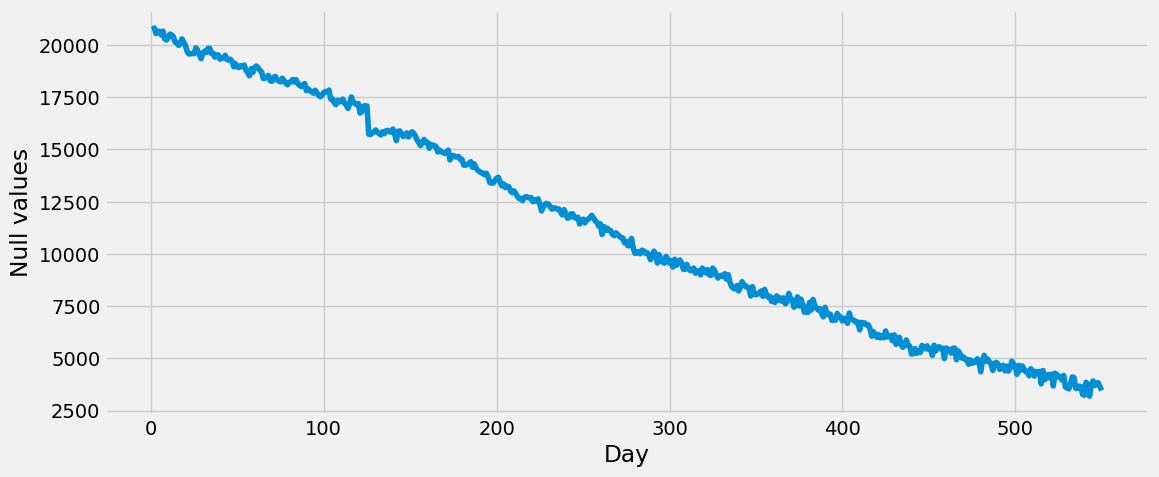

In [8]:
days = [r for r in range(1, len(train_1.columns))]
plt.figure(figsize=(12,5))
plt.xlabel('Day')
plt.ylabel('Null values')
plt.plot(days, train_1.isnull().sum()[1:])

# Observation:

We see that the number of nan values decrease with time.

#Explanation:

Some web pages have all nan values in the begining, that can be due to the fact that those were created after that time so there is no traffic reading for that time.

In [9]:
# Check for null values
train_1.isnull().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

In [10]:
print(train_1.shape)
train_1=train_1.dropna(how='all')
#‘all’ : If all values are NA, drop that row or column.
print(train_1.shape)

train_1=train_1.dropna(thresh=300)
print(train_1.shape)

(145063, 551)
(145063, 551)
(133617, 551)


1) Drop the rows that have all values as nan, none in our case.

2) Drop rows that have nan more than 300 days, because the time series will be meaningless.

In [11]:
train_1=train_1.fillna(0)
train_1

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145012,Legión_(Marvel_Comics)_es.wikipedia.org_all-ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,3.0,2.0,4.0,2.0,4.0,4.0,1.0,2.0,2.0
145013,Referéndum_sobre_la_permanencia_del_Reino_Unid...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,16.0,8.0,3.0,6.0,3.0,3.0,10.0,11.0,3.0
145014,Salida_del_Reino_Unido_de_la_Unión_Europea_es....,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,36.0,23.0,182.0,43.0,8.0,22.0,13.0,18.0,14.0
145015,"Amar,_después_de_amar_es.wikipedia.org_all-acc...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,30.0,27.0,14.0,8.0,7.0,5.0,43.0,12.0,25.0


In [12]:
# Adjusted regular expression to capture all parts correctly
page_info = train_1['Page'].str.extract(r'^(.*?)(?:_(zh|fr|en|ru|de|ja|es))?(?:[_\.](britanica\.org|wikipedia\.org|www\.wikipedia\.org|wikimedia\.org|www\.wikimedia\.org|mediawiki\.org|www\.mediawiki\.org))_(all-access|mobile-web|desktop)_(all-agents|spider)$')
page_info.columns = ['Title', 'Language', 'Domain', 'Access_Type', 'Access_Origin']

# Combine the extracted info with the original dataset
train_1 = pd.concat([page_info, train_1.drop(columns=['Page'])], axis=1)

train_1.head(5)

,Title,Language,Domain,Access_Type,Access_Origin,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,wikipedia.org,all-access,spider,18.0,11.0,5.0,13.0,14.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM,zh,wikipedia.org,all-access,spider,11.0,14.0,15.0,18.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C,zh,wikipedia.org,all-access,spider,1.0,0.0,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute,zh,wikipedia.org,all-access,spider,35.0,13.0,10.0,94.0,4.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566,zh,wikipedia.org,all-access,spider,12.0,7.0,4.0,5.0,20.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


In [13]:
train_1.isnull().sum()

Title                0
Language         14494
Domain               0
Access_Type          0
Access_Origin        0
                 ...  
2016-12-27           0
2016-12-28           0
2016-12-29           0
2016-12-30           0
2016-12-31           0
Length: 555, dtype: int64

In [14]:
# Fill or handle null values, if any
df=train_1.copy()
df = df.dropna()
train_1.isnull().sum()

Title                0
Language         14494
Domain               0
Access_Type          0
Access_Origin        0
                 ...  
2016-12-27           0
2016-12-28           0
2016-12-29           0
2016-12-30           0
2016-12-31           0
Length: 555, dtype: int64

In [15]:
train_1.head()

,Title,Language,Domain,Access_Type,Access_Origin,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,wikipedia.org,all-access,spider,18.0,11.0,5.0,13.0,14.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM,zh,wikipedia.org,all-access,spider,11.0,14.0,15.0,18.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C,zh,wikipedia.org,all-access,spider,1.0,0.0,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute,zh,wikipedia.org,all-access,spider,35.0,13.0,10.0,94.0,4.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566,zh,wikipedia.org,all-access,spider,12.0,7.0,4.0,5.0,20.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


In [16]:
#Rows with missing 'Language' values
train_1[train_1['Domain'] == 'www.mediawiki.org'].head(5)

,Title,Language,Domain,Access_Type,Access_Origin,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
19614,API,NaN,www.mediawiki.org,all-access,all-agents,528.0,587.0,634.0,483.0,510.0,...,479.0,317.0,234.0,598.0,283.0,399.0,334.0,351.0,358.0,275.0
19615,API:Account_creation,NaN,www.mediawiki.org,all-access,all-agents,37.0,38.0,46.0,41.0,79.0,...,55.0,37.0,23.0,387.0,35.0,38.0,38.0,28.0,45.0,41.0
19616,API:Allimages,NaN,www.mediawiki.org,all-access,all-agents,19.0,31.0,19.0,10.0,32.0,...,23.0,13.0,8.0,370.0,6.0,23.0,14.0,18.0,16.0,11.0
19617,API:Allpages,NaN,www.mediawiki.org,all-access,all-agents,32.0,29.0,14.0,15.0,23.0,...,27.0,25.0,15.0,375.0,18.0,24.0,29.0,17.0,27.0,27.0
19618,API:Backlinks,NaN,www.mediawiki.org,all-access,all-agents,29.0,16.0,15.0,19.0,18.0,...,26.0,22.0,17.0,382.0,18.0,29.0,21.0,21.0,35.0,20.0


In [17]:
df.groupby('Language').count()

,Title,Domain,Access_Type,Access_Origin,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
Language,,,,,,,,,,,,,,,,,,,,,
de,17362,17362,17362,17362,17362,17362,17362,17362,17362,17362,...,17362,17362,17362,17362,17362,17362,17362,17362,17362,17362
en,22486,22486,22486,22486,22486,22486,22486,22486,22486,22486,...,22486,22486,22486,22486,22486,22486,22486,22486,22486,22486
es,13551,13551,13551,13551,13551,13551,13551,13551,13551,13551,...,13551,13551,13551,13551,13551,13551,13551,13551,13551,13551
fr,16948,16948,16948,16948,16948,16948,16948,16948,16948,16948,...,16948,16948,16948,16948,16948,16948,16948,16948,16948,16948
ja,19295,19295,19295,19295,19295,19295,19295,19295,19295,19295,...,19295,19295,19295,19295,19295,19295,19295,19295,19295,19295
ru,14270,14270,14270,14270,14270,14270,14270,14270,14270,14270,...,14270,14270,14270,14270,14270,14270,14270,14270,14270,14270
zh,15211,15211,15211,15211,15211,15211,15211,15211,15211,15211,...,15211,15211,15211,15211,15211,15211,15211,15211,15211,15211


In [18]:
df_language=df.drop(["Title", "Domain", "Access_Type", "Access_Origin"], axis=1)
df_language=df_language.groupby('Language').mean().transpose()
df_language

Language,de,en,es,fr,ja,ru,zh
2015-07-01,763.765926,3767.328604,1127.485204,499.092872,614.637160,663.199229,272.498521
2015-07-02,753.362861,3755.158765,1077.485425,502.297852,705.813216,674.677015,272.906778
2015-07-03,723.074415,3565.225696,990.895949,483.007553,637.451671,625.329783,271.097167
2015-07-04,663.537323,3711.782932,930.303151,516.275785,800.897435,588.171829,273.712379
2015-07-05,771.358657,3833.433025,1011.759575,506.871666,768.352319,626.385354,291.977713
...,...,...,...,...,...,...,...
2016-12-27,1119.596936,6314.335275,1070.923400,840.590217,808.541436,998.374071,363.066991
2016-12-28,1062.284069,6108.874144,1108.996753,783.585379,807.430163,945.054730,369.049701
2016-12-29,1033.939062,6518.058525,1058.660320,763.209169,883.752786,909.352207,340.526330
2016-12-30,981.786430,5401.792360,807.551177,710.502773,979.278777,815.475123,342.745316


In [19]:
df_language.index=pd.to_datetime(df_language.index)
df_language.index

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=550, freq=None)

In [20]:
train_1['Language'].value_counts(normalize=True)

Language
en    0.188763
ja    0.161975
de    0.145749
fr    0.142273
zh    0.127692
ru    0.119792
es    0.113756
Name: proportion, dtype: float64

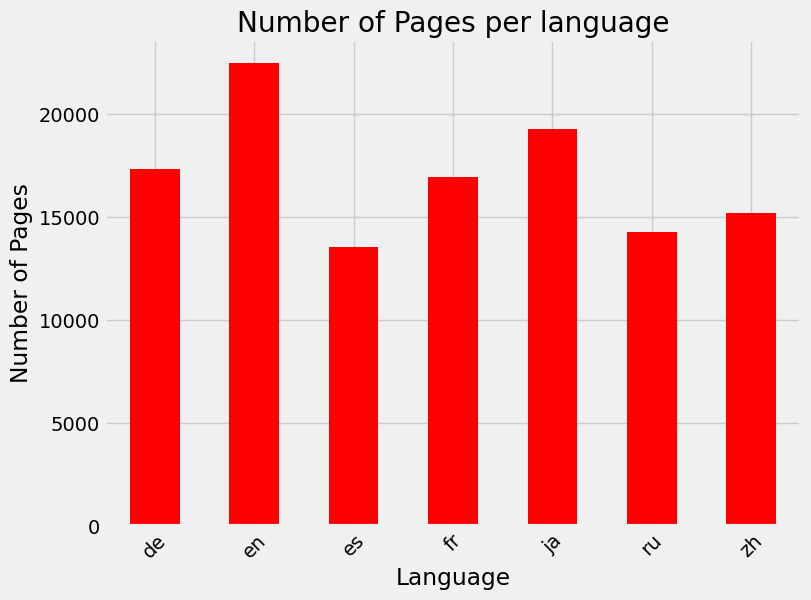

In [21]:
plt.figure(figsize=(8, 6))
train_1.groupby("Language")["Title"].count().plot(kind="bar", color='r')
plt.xlabel("Language")
plt.xticks(rotation=45)
plt.ylabel("Number of Pages")
plt.title("Number of Pages per language")
plt.show()

In [22]:
train_1['Access_Type'].value_counts()

Access_Type
all-access    68718
mobile-web    33299
desktop       31600
Name: count, dtype: int64

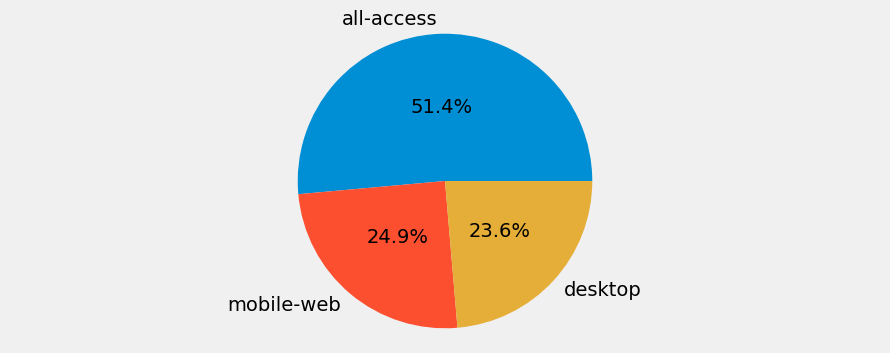

In [23]:
X = (train_1["Access_Type"].value_counts(dropna=False, normalize=True) * 100).values
y = (train_1["Access_Type"].value_counts(dropna=False, normalize=True) * 100).index
plt.figure(figsize=(10, 4)) # Adjust the width and height as needed
plt.pie(X, labels=y, radius=1.5, autopct='%1.1f%%', pctdistance=0.5)
plt.axis('equal')
plt.show()

In [24]:
train_1['Access_Origin'].value_counts()

Access_Origin
all-agents    101303
spider         32314
Name: count, dtype: int64

In [25]:
train_1['Domain'].value_counts()

Domain
wikipedia.org        119123
wikimedia.org          8266
www.mediawiki.org      6228
Name: count, dtype: int64

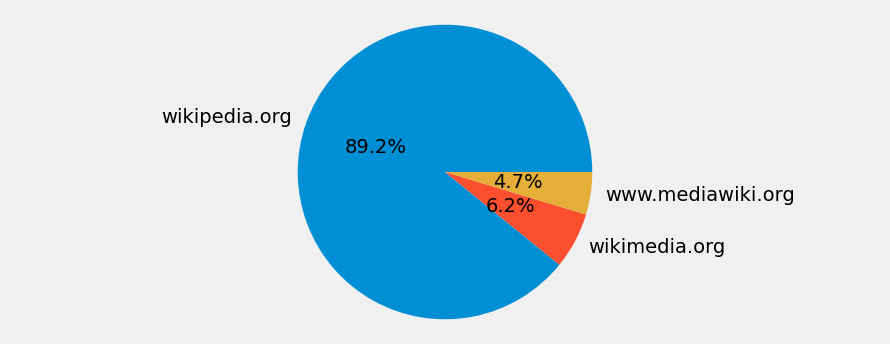

In [26]:
X = (train_1["Domain"].value_counts(dropna=False, normalize=True) * 100).values
y = (train_1["Domain"].value_counts(dropna=False, normalize=True) * 100).index
plt.figure(figsize=(10, 4)) # Adjust the width and height as needed
plt.pie(X, labels=y, radius=1.5, autopct='%1.1f%%', pctdistance=0.5)
plt.axis('equal')
plt.show()

In [27]:
train_1.isnull().sum()

Title                0
Language         14494
Domain               0
Access_Type          0
Access_Origin        0
                 ...  
2016-12-27           0
2016-12-28           0
2016-12-29           0
2016-12-30           0
2016-12-31           0
Length: 555, dtype: int64

In [28]:
train_1.shape

(133617, 555)

In [29]:
train_1.isnull().sum()

Title                0
Language         14494
Domain               0
Access_Type          0
Access_Origin        0
                 ...  
2016-12-27           0
2016-12-28           0
2016-12-29           0
2016-12-30           0
2016-12-31           0
Length: 555, dtype: int64

In [30]:
train_1.shape

(133617, 555)

In [31]:
df_language.reset_index(inplace=True)
df_language.set_index('index', inplace=True)

Text(0, 0.5, 'Views per Page')

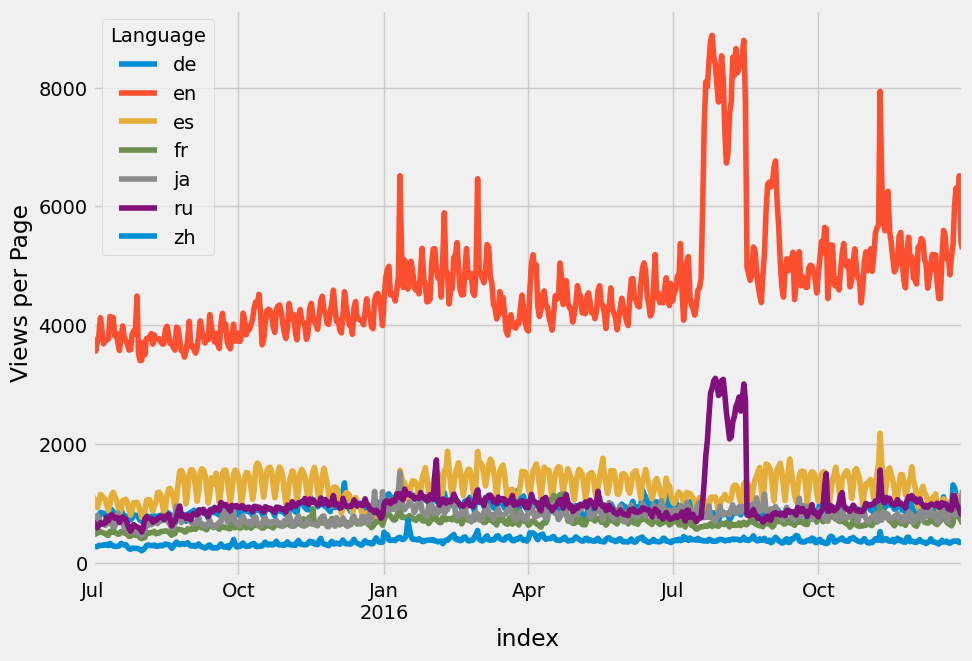

In [32]:
df_language.plot(figsize=(10,7))
plt.ylabel('Views per Page')

# Observations:

Plotting the aggregated dataset shows us that web pages in English get the most number of views as compared to different languages, there are some spikes at different times in different languages.


# Plotting for English

Plotting just for english because we are going to use this for our furthur investigation and predictions.

Text(0, 0.5, 'Views per Page')

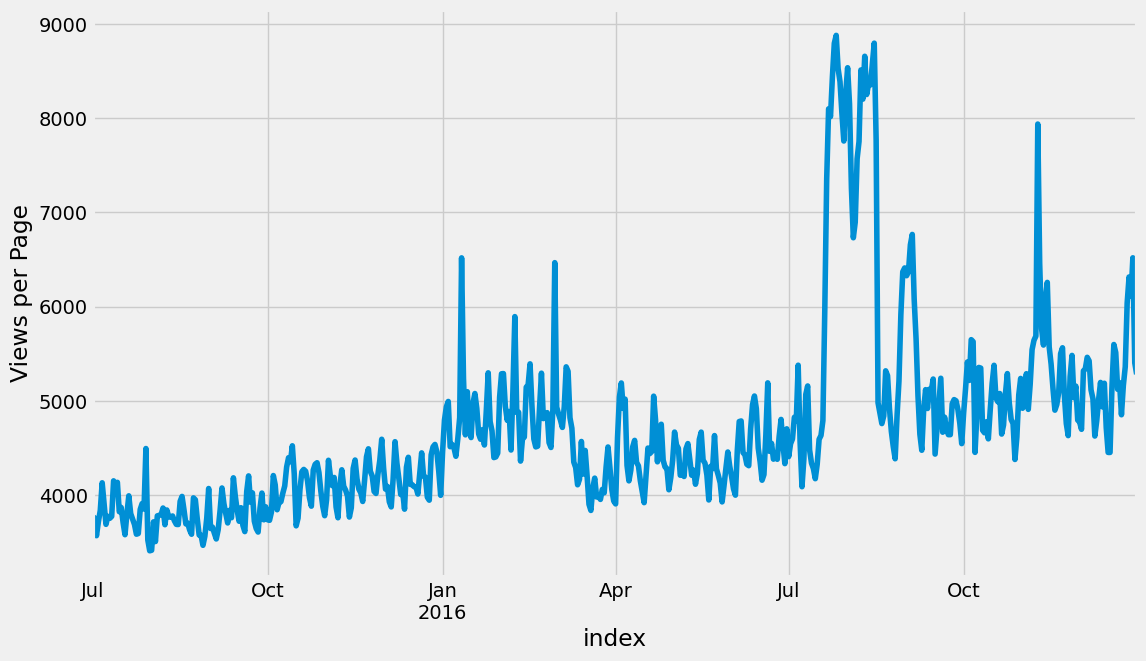

In [33]:
df_language['en'].plot(figsize=(12,7))
plt.ylabel('Views per Page')

In [34]:
from statsmodels.tsa.stattools import adfuller

# Check if the data is stationary
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print('Series is non-stationary')
    else:
        print('Series is stationary')

In [35]:
check_stationarity(df_language['zh'])

ADF Statistic: -1.9216658696729183
p-value: 0.3219384419565085
Series is non-stationary


In [36]:
check_stationarity(df_language['en'])

ADF Statistic: -2.373562974569941
p-value: 0.14933749437355304
Series is non-stationary


#Time series decomposition

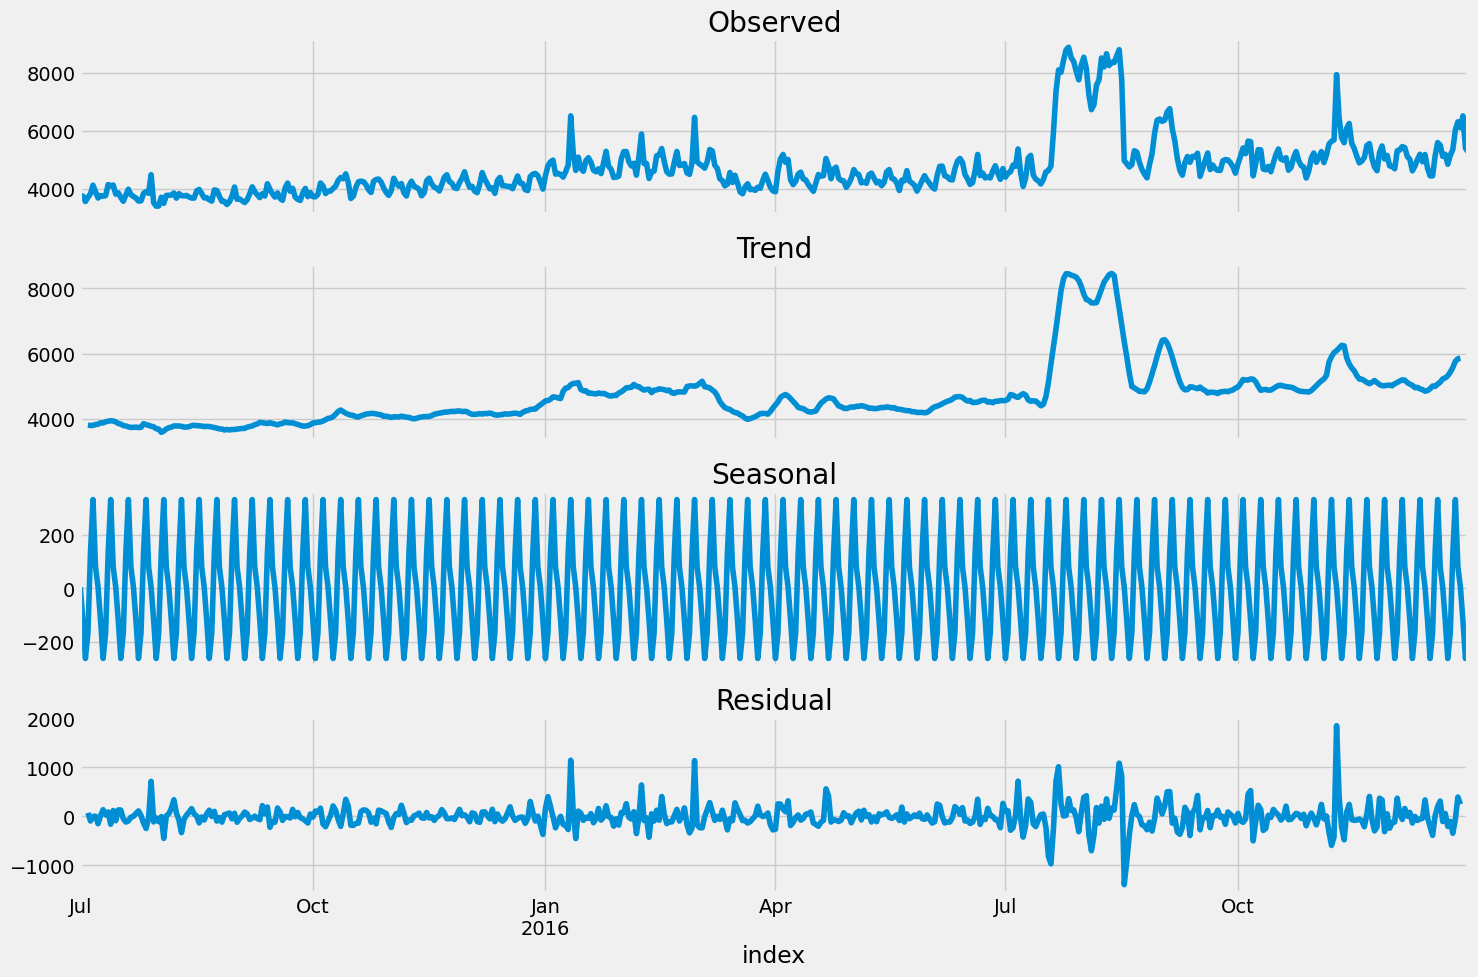

In [37]:
# Naive decomposition of our Time Series as explained above
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform seasonal decomposition
result = seasonal_decompose(df_language['en'], model='additive')

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

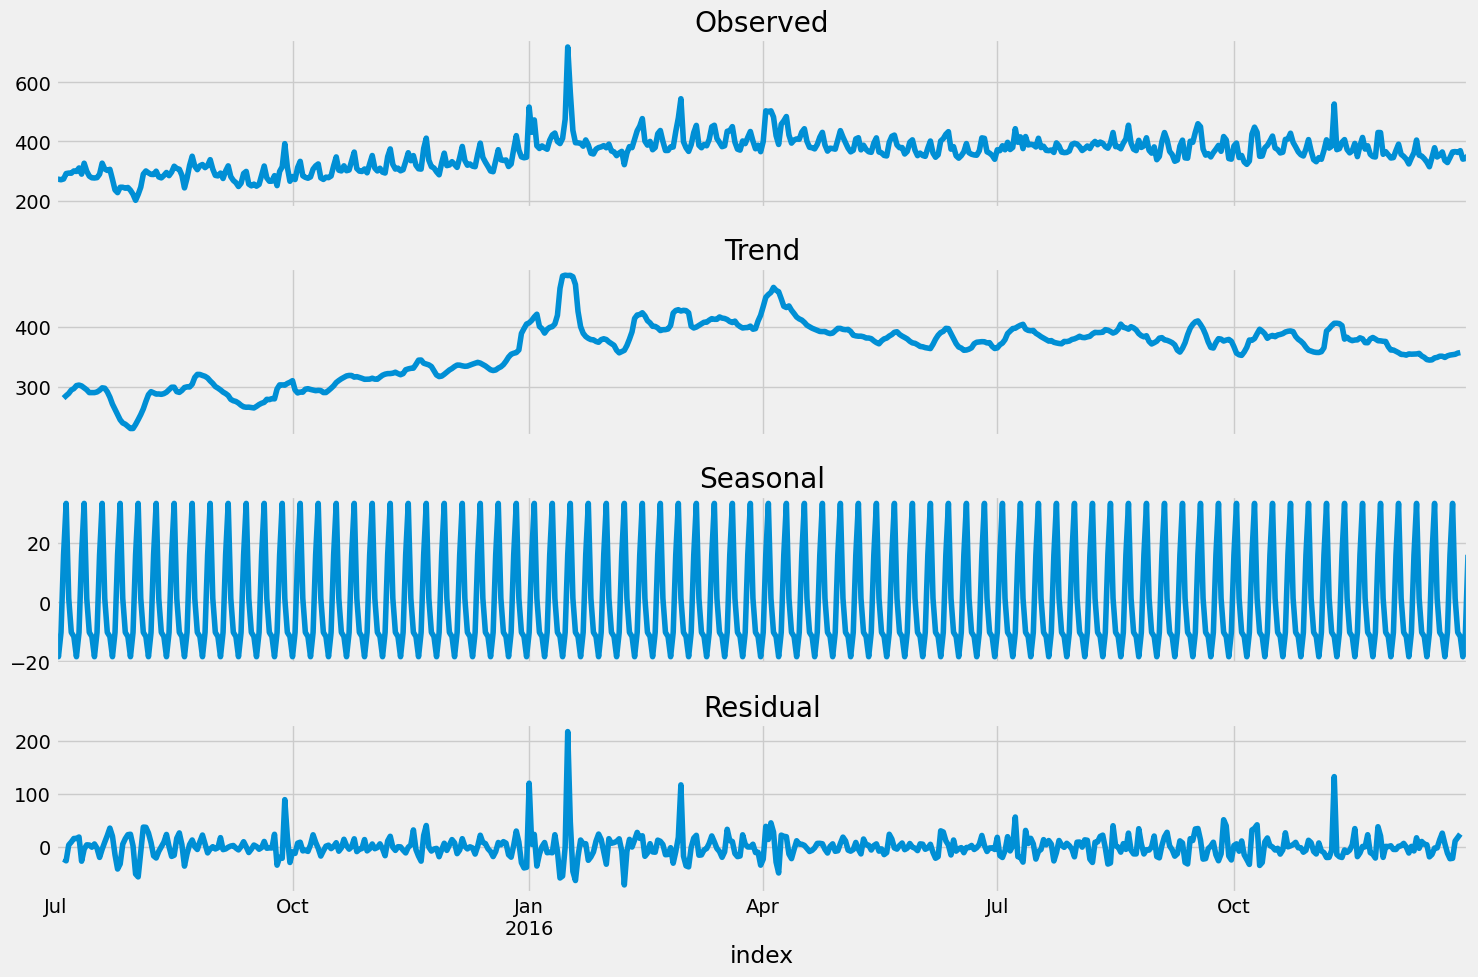

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform seasonal decomposition
result = seasonal_decompose(df_language['zh'], model='additive')

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

In [39]:
# Taking only a language-based subset of the entire dataset for demonstration
train_en_sample = train_1[train_1['Language'] == 'en']
# Taking only a language-based subset of the entire dataset for demonstration
train_zh_sample = train_1[train_1['Language'] == 'zh']
# Taking only a language-based subset of the entire dataset for demonstration
train_es_sample = train_1[train_1['Language'] == 'es']
# Taking only a language-based subset of the entire dataset for demonstration
train_de_sample = train_1[train_1['Language'] == 'de']
train_en_sample.head()
# Taking only a language-based subset of the entire dataset for demonstration
train_es_sample = train_1[train_1['Language'] == 'es']
train_es_sample.head()
# Taking only a language-based subset of the entire dataset for demonstration
train_fr_sample = train_1[train_1['Language'] == 'fr']
train_fr_sample.head()
# Taking only a language-based subset of the entire dataset for demonstration
train_ru_sample = train_1[train_1['Language'] == 'ru']
train_ru_sample.head()

,Title,Language,Domain,Access_Type,Access_Origin,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
15882,14/88,ru,wikipedia.org,mobile-web,all-agents,870.0,901.0,1034.0,773.0,759.0,...,942.0,943.0,952.0,867.0,957.0,873.0,847.0,804.0,801.0,650.0
15883,5sta_Family,ru,wikipedia.org,mobile-web,all-agents,982.0,897.0,1046.0,1159.0,1150.0,...,229.0,272.0,468.0,276.0,239.0,246.0,394.0,263.0,235.0,898.0
15884,ABBA,ru,wikipedia.org,mobile-web,all-agents,253.0,266.0,5710.0,1625.0,567.0,...,322.0,362.0,517.0,537.0,350.0,423.0,558.0,638.0,846.0,3019.0
15885,Adidas,ru,wikipedia.org,mobile-web,all-agents,285.0,284.0,351.0,349.0,343.0,...,515.0,670.0,521.0,547.0,448.0,421.0,433.0,412.0,444.0,372.0
15886,Alekseev,ru,wikipedia.org,mobile-web,all-agents,0.0,0.0,0.0,0.0,0.0,...,721.0,664.0,1092.0,744.0,608.0,586.0,611.0,639.0,786.0,1920.0


In [40]:
# Melt the dataset to long format

train_en = train_en_sample.melt(id_vars=['Title', 'Language', 'Domain', 'Access_Type', 'Access_Origin'], var_name='Date', value_name='Views')

# Convert the 'Date' column to datetime format
train_en['Date'] = pd.to_datetime(train_en['Date'])
train_en.head()


,Title,Language,Domain,Access_Type,Access_Origin,Date,Views
0,!vote,en,wikipedia.org,desktop,all-agents,2015-07-01,3.0
1,"""Weird_Al""_Yankovic",en,wikipedia.org,desktop,all-agents,2015-07-01,2403.0
2,100_metres,en,wikipedia.org,desktop,all-agents,2015-07-01,982.0
3,10_Cloverfield_Lane,en,wikipedia.org,desktop,all-agents,2015-07-01,0.0
4,10_Gigabit_Ethernet,en,wikipedia.org,desktop,all-agents,2015-07-01,1078.0


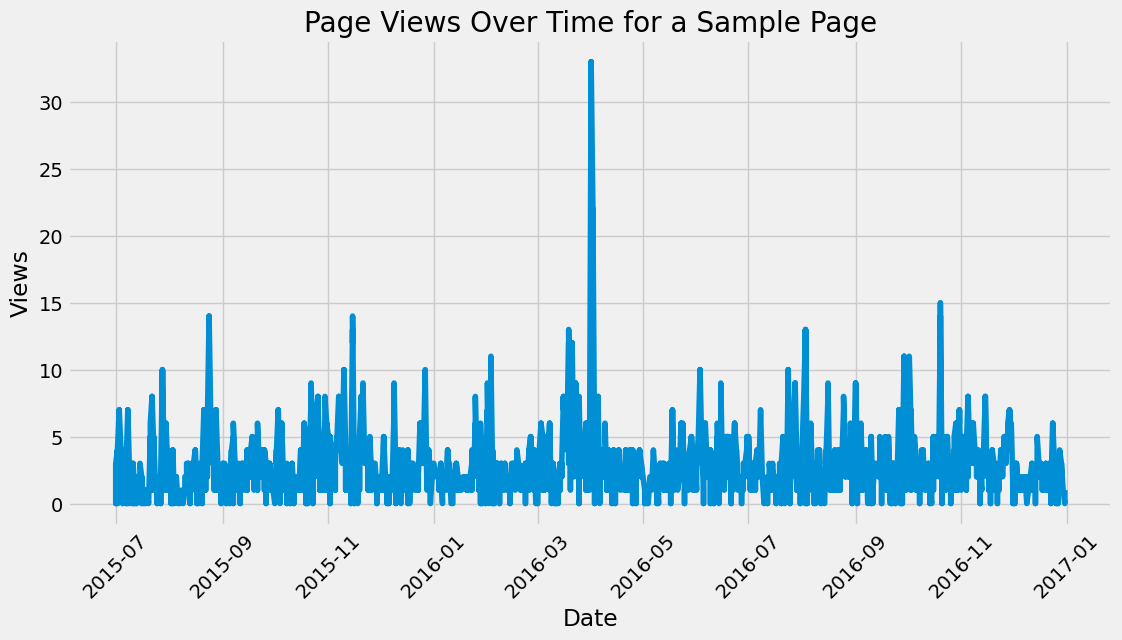

In [41]:
# Plot time series for a sample page
sample_page = train_en[train_en['Title'] == train_en['Title'].unique()[0]]
plt.figure(figsize=(12, 6))
plt.plot(sample_page['Date'], sample_page['Views'])
plt.xlabel('Date')
plt.ylabel('Views')
plt.title('Page Views Over Time for a Sample Page')
plt.xticks(rotation=45)
plt.show()

In [42]:
# Melt the dataset to long format
train_zh = train_zh_sample.melt(id_vars=['Title', 'Language', 'Domain', 'Access_Type', 'Access_Origin'], var_name='Date', value_name='Views')

# Convert the 'Date' column to datetime format
train_zh['Date'] = pd.to_datetime(train_zh['Date'])
train_zh.head()

,Title,Language,Domain,Access_Type,Access_Origin,Date,Views
0,2NE1,zh,wikipedia.org,all-access,spider,2015-07-01,18.0
1,2PM,zh,wikipedia.org,all-access,spider,2015-07-01,11.0
2,3C,zh,wikipedia.org,all-access,spider,2015-07-01,1.0
3,4minute,zh,wikipedia.org,all-access,spider,2015-07-01,35.0
4,5566,zh,wikipedia.org,all-access,spider,2015-07-01,12.0


In [43]:
!pip install prophet

In [44]:
# Assuming the dates for 'Exog' data start from the same date as the original data
start_date = train_en['Date'].min()
exog_campaign['Date'] = pd.date_range(start=start_date, periods=len(exog_campaign), freq='D')
# Prepare the data
exog_campaign = exog_campaign.rename(columns={'Exog': 'Campaign'})
exog_campaign.head()

,Campaign,Date
0,0,2015-07-01
1,0,2015-07-02
2,0,2015-07-03
3,0,2015-07-04
4,0,2015-07-05


In [45]:
# Check stationarity for a sample page in English
sample_title =  '10_Gigabit_Ethernet'  # Replace with an actual title from the unique values
sample_language = 'en'         # Replace with an actual language from the unique values
access_type = 'desktop'
access_origin = 'all-agents'

# Check for unique values in 'Title' and 'Language' to ensure they exist
print(train_en['Title'].unique())
print(train_en['Language'].unique())

sample_page_en = train_en[(train_en['Title'] == sample_title) & (train_en['Language'] == sample_language) & (train_en['Access_Type'] == access_type) & (train_en['Access_Origin'] == access_origin)]

# Ensure sample_page is not empty before running the test
if not sample_page_en.empty:
    check_stationarity(sample_page_en['Views'])
else:
    print(f"No data found for Title: {sample_title} and Language: {sample_language}")

sample_page_en.head(10)

['!vote' '"Weird_Al"_Yankovic' '100_metres' ... 'Zitadelle'
 'Zovashen_(Dzhannatlu),_Ararat' 'Zurich.minds']
['en']
ADF Statistic: -3.364087959019702
p-value: 0.012245756365523735
Series is stationary


,Title,Language,Domain,Access_Type,Access_Origin,Date,Views
4,10_Gigabit_Ethernet,en,wikipedia.org,desktop,all-agents,2015-07-01,1078.0
22490,10_Gigabit_Ethernet,en,wikipedia.org,desktop,all-agents,2015-07-02,1116.0
44976,10_Gigabit_Ethernet,en,wikipedia.org,desktop,all-agents,2015-07-03,869.0
67462,10_Gigabit_Ethernet,en,wikipedia.org,desktop,all-agents,2015-07-04,327.0
89948,10_Gigabit_Ethernet,en,wikipedia.org,desktop,all-agents,2015-07-05,312.0
112434,10_Gigabit_Ethernet,en,wikipedia.org,desktop,all-agents,2015-07-06,1123.0
134920,10_Gigabit_Ethernet,en,wikipedia.org,desktop,all-agents,2015-07-07,1124.0
157406,10_Gigabit_Ethernet,en,wikipedia.org,desktop,all-agents,2015-07-08,1149.0
179892,10_Gigabit_Ethernet,en,wikipedia.org,desktop,all-agents,2015-07-09,1128.0
202378,10_Gigabit_Ethernet,en,wikipedia.org,desktop,all-agents,2015-07-10,1003.0


# Random sample time series from the language 'EN'

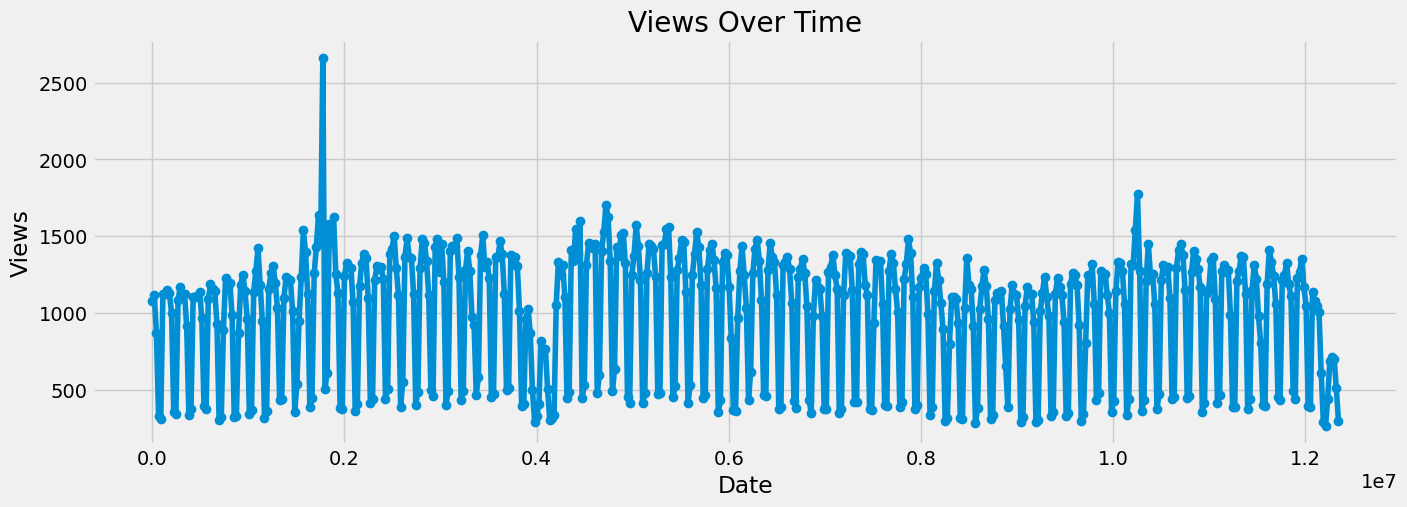

In [46]:
# Sample Page
plt.figure(figsize=(15, 5))  # Adjust the width and height as needed
sample_page_en.Views.plot(style='-o')
plt.xlabel('Date')  # Add a label for the x-axis
plt.ylabel('Views')  # Add a label for the y-axis
plt.title('Views Over Time')  # Add a title
plt.show()

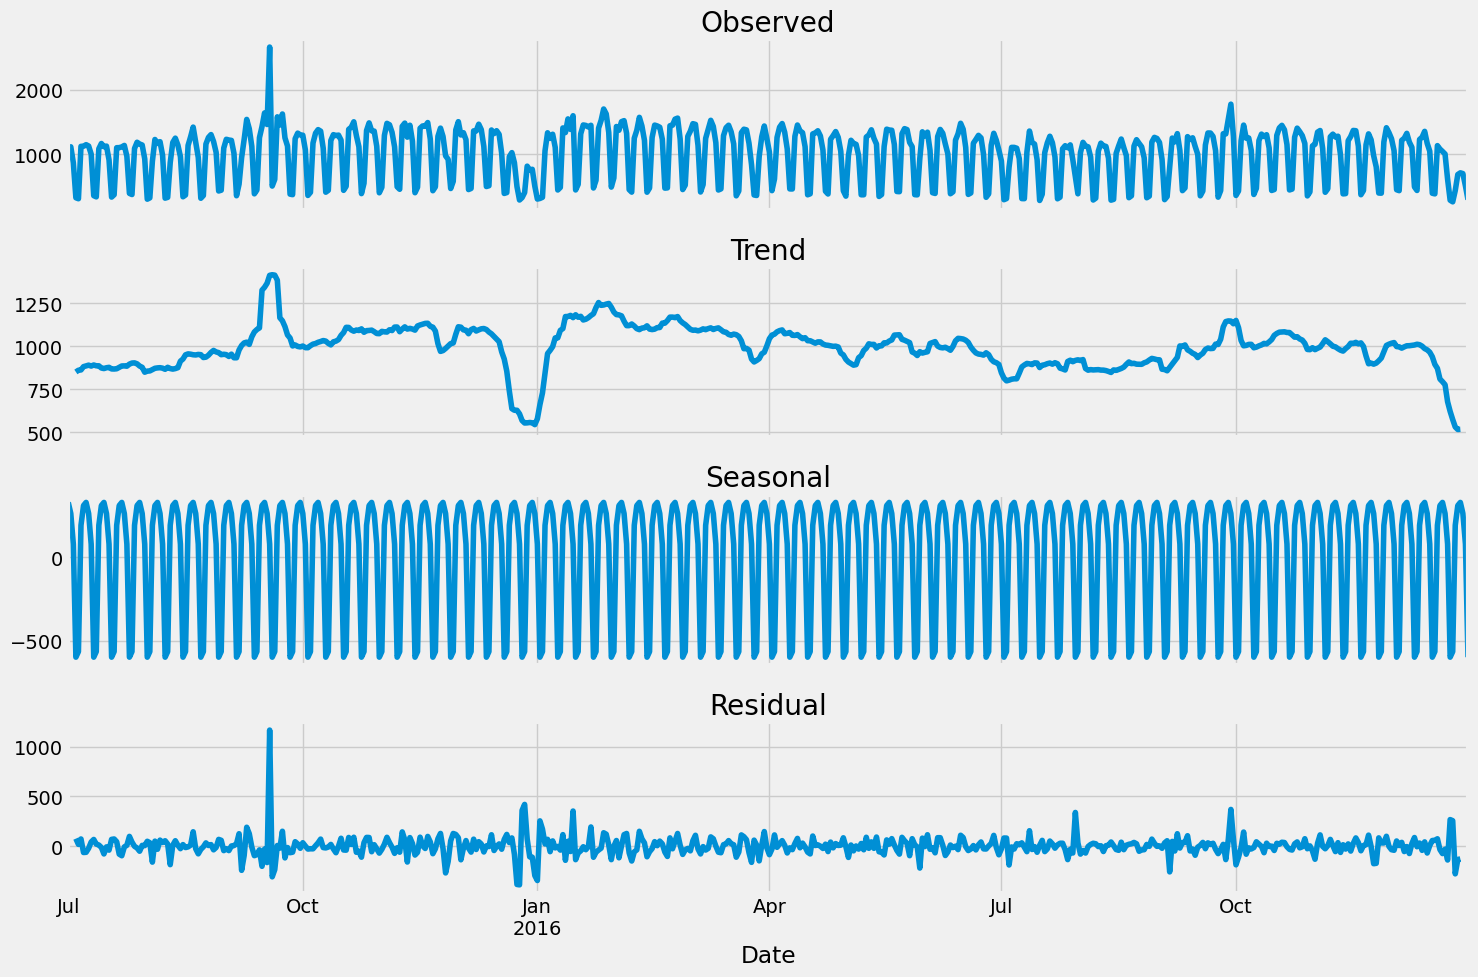

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Ensure the data is sorted by date
sample_page_en = sample_page_en.sort_values(by='Date')

# Perform seasonal decomposition
result = seasonal_decompose(sample_page_en.set_index('Date')['Views'], model='additive')

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

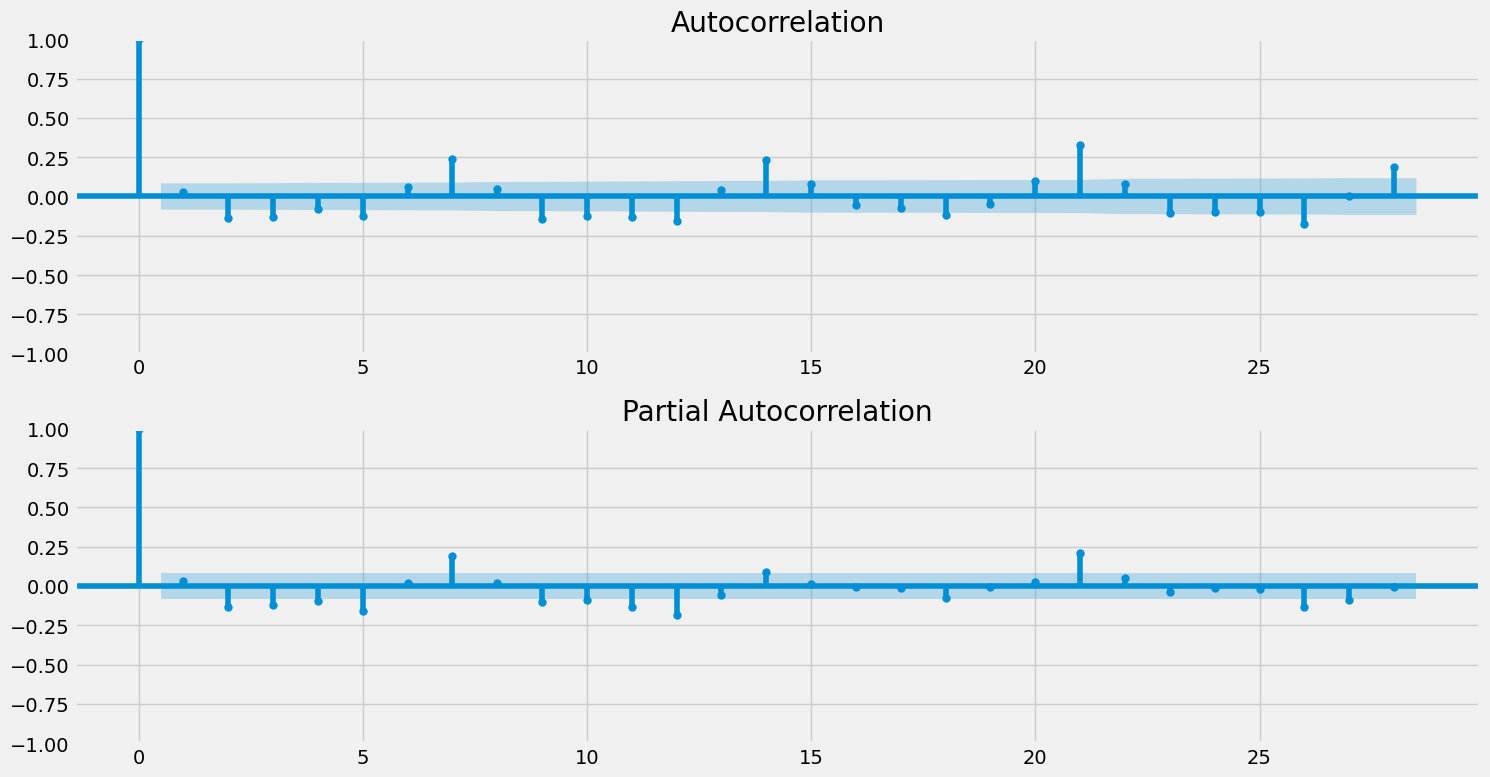

In [48]:
# Differencing the Series
df_en_diff = df_language.copy()
df_en_diff['en'] = df_en_diff['en'].diff()

# Plotting the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(df_en_diff['en'].dropna(), ax=ax1)
plot_pacf(df_en_diff['en'].dropna(), ax=ax2)
plt.tight_layout()
plt.show()

In [49]:
# Check stationarity for a sample page
sample_title =  '2NE1'  # Replace with an actual title from the unique values
sample_language = 'zh'  # Replace with an actual language from the unique values
access_type = 'all-access'
access_origin = 'spider'

# Check for unique values in 'Title' and 'Language' to ensure they exist
print(train_zh['Title'].unique())
print(train_zh['Language'].unique())

sample_page_zh = train_zh[(train_zh['Title'] == sample_title) & (train_zh['Language'] == sample_language) & (train_zh['Access_Type'] == access_type) & (train_zh['Access_Origin'] == access_origin)]

# Ensure sample_page is not empty before running the test
if not sample_page_zh.empty:
    check_stationarity(sample_page_zh['Views'])
else:
    print(f"No data found for Title: {sample_title} and Language: {sample_language}")
#Display
sample_page_zh.head()

['2NE1' '2PM' '3C' ... '冰原歷險記：笑星撞地球' '黃柏翔' '警徽天職4']
['zh']
ADF Statistic: -8.884037701518485
p-value: 1.2946704090247951e-14
Series is stationary


,Title,Language,Domain,Access_Type,Access_Origin,Date,Views
0,2NE1,zh,wikipedia.org,all-access,spider,2015-07-01,18.0
15211,2NE1,zh,wikipedia.org,all-access,spider,2015-07-02,11.0
30422,2NE1,zh,wikipedia.org,all-access,spider,2015-07-03,5.0
45633,2NE1,zh,wikipedia.org,all-access,spider,2015-07-04,13.0
60844,2NE1,zh,wikipedia.org,all-access,spider,2015-07-05,14.0


# Random sample time series from the language 'zh'

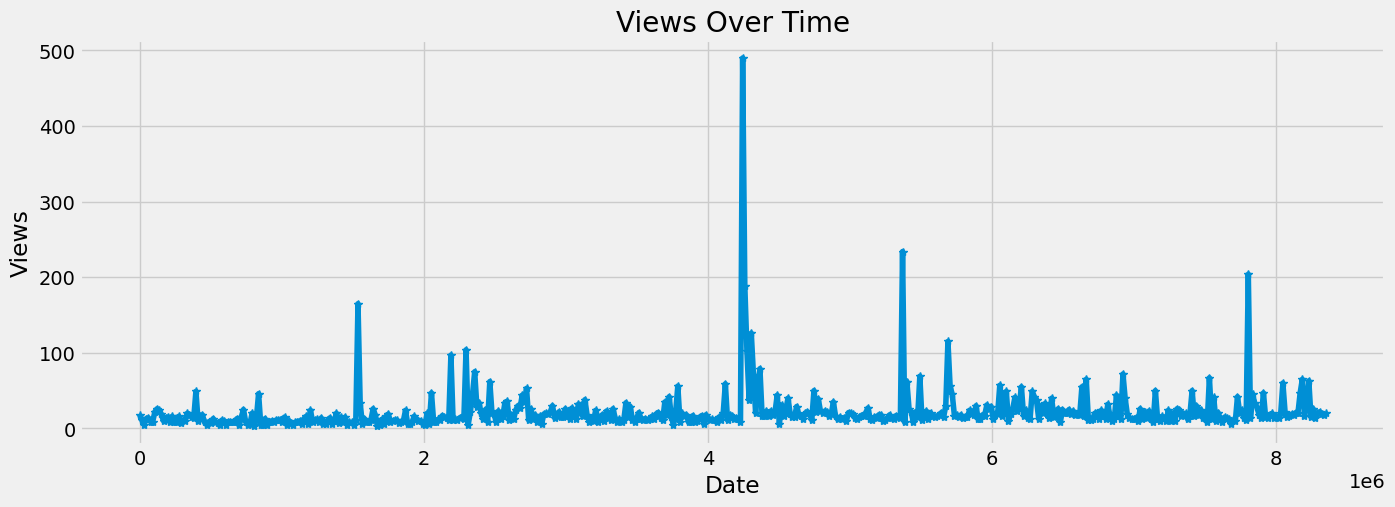

In [50]:
# Sample Page
plt.figure(figsize=(15, 5))  # Adjust the width and height as needed
sample_page_zh.Views.plot(style='-*')
plt.xlabel('Date')  # Add a label for the x-axis
plt.ylabel('Views')  # Add a label for the y-axis
plt.title('Views Over Time')  # Add a title
plt.show()

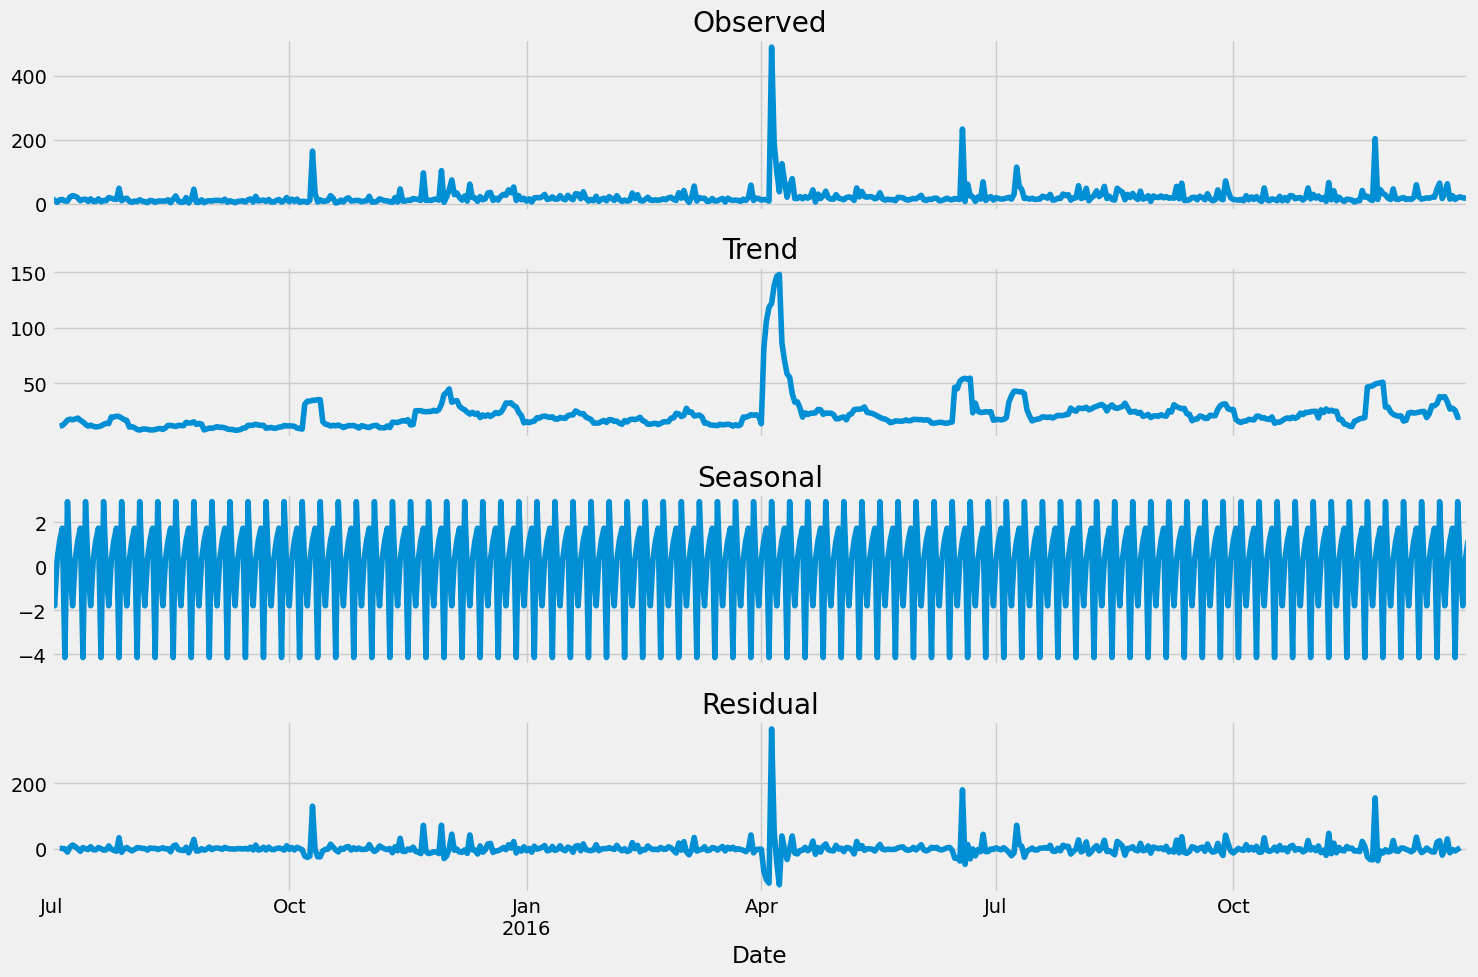

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Ensure the data is sorted by date
sample_page_zh = sample_page_zh.sort_values(by='Date')

# Perform seasonal decomposition
result = seasonal_decompose(sample_page_zh.set_index('Date')['Views'], model='additive')

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

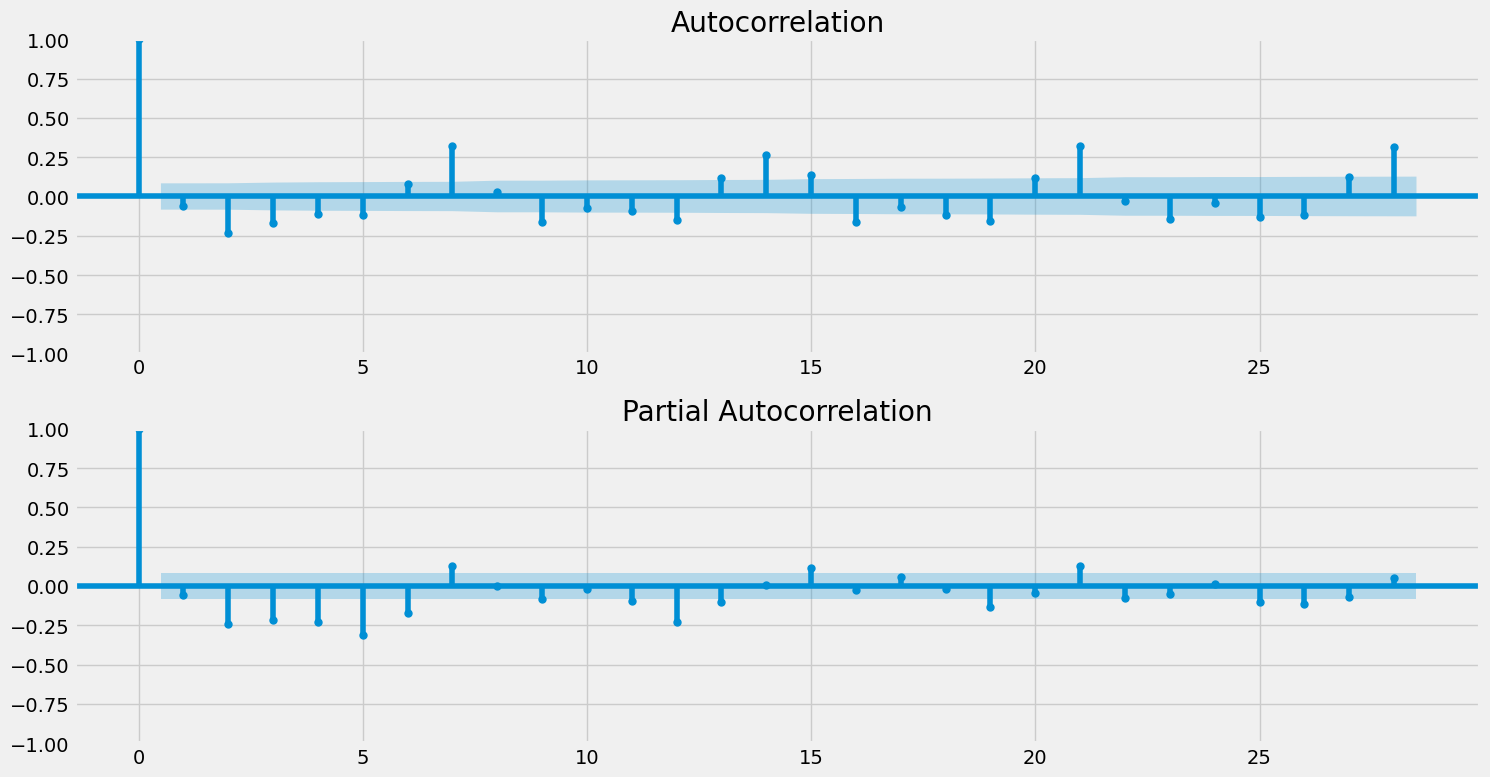

In [52]:
# Differencing the Series
df_zh_diff = df_language.copy()
df_zh_diff['zh'] = df_zh_diff['zh'].diff()

# Plotting the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(df_zh_diff['zh'].dropna(), ax=ax1)
plot_pacf(df_zh_diff['zh'].dropna(), ax=ax2)
plt.tight_layout()
plt.show()

In [71]:
# Split the data into training and testing sets
def train_test_split_time_series(data, train_size=0.8):
    data = data.sort_values(by='Date')
    split_index = int(len(data) * train_size)
    train, test = data[:split_index], data[split_index:]
    return train, test

In [72]:
#ARIMA and SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

def forecast_arima(train, test, order):
    model = ARIMA(train, order=order)
    result = model.fit()
    forecast = result.forecast(steps=len(test), alpha=0.05)
    return forecast

def forecast_sarimax_english(train, test, order, seasonal_order, exog_train, exog_test):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, exog=exog_train)
    result = model.fit()
    forecast = result.forecast(steps=len(test), alpha=0.05, exog=exog_test)
    return forecast

def forecast_sarimax_non_english(train, test, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, alpha=0.05)
    result = model.fit()
    forecast = result.forecast(steps=len(test))
    return forecast

In [73]:
#FB Prophet
from prophet import Prophet

def train_prophet_model_english(train, exog_campaign):
    # Preparing the data for Prophet
    prophet_data = train[['Date', 'Views']].rename(columns={'Date': 'ds', 'Views': 'y'})
    prophet_data = prophet_data.merge(exog_campaign, left_on='ds', right_on='Date', how='left').drop(columns=['Date'])
    print(prophet_data.head())

    # Train the model
    prophet_model = Prophet()
    prophet_model.add_regressor('Campaign')
    prophet_model.fit(prophet_data)

    return prophet_model

def forecast_with_prophet_english(prophet_model, train, test, exog_campaign):
    # Make a future dataframe and forecast
    future = prophet_model.make_future_dataframe(periods=len(test))

    # Ensure 'Campaign' column has the same length as 'future'
    exog_train_test = pd.concat([train[['Date']], test[['Date']]], ignore_index=True)
    exog_train_test = exog_train_test.merge(exog_campaign, on='Date', how='left').sort_values(by='Date').reset_index(drop=True)
    future['Campaign'] = exog_train_test['Campaign'].values

    forecast = prophet_model.predict(future)
    return forecast

def train_prophet_model_non_english(train):
    # Preparing the data for Prophet
    prophet_data = train[['Date', 'Views']].rename(columns={'Date': 'ds', 'Views': 'y'})

    # Train the model
    prophet_model = Prophet()
    prophet_model.fit(prophet_data)

    return prophet_model

def forecast_with_prophet_non_english(prophet_model, periods):
    # Make a future dataframe and forecast
    future = prophet_model.make_future_dataframe(periods=periods)
    forecast = prophet_model.predict(future)
    return forecast

In [74]:
#Split the data into training and testing sets
train = df_language[:-20]
test = df_language[-20:]#Split the data into training and testing sets
train_en, test_en = train['en'], test['en']
train_zh, test_zh = train['zh'], test['zh']

In [75]:
train_en.shape, test_en.shape

((530,), (20,))

In [76]:
train_zh.shape, test_zh.shape

((530,), (20,))

In [77]:
!pip install pmdarima

# Hyperparameter Tuning for ARIMA

In [78]:
from sklearn.model_selection import ParameterGrid
import pmdarima as pm
from pmdarima import arima
from sklearn.metrics import mean_squared_error

def grid_search_arima(y_train, y_test, params):
    grid = ParameterGrid(params)
    best_score, best_cfg = float("inf"), None
    for param in grid:
        try:
            model = arima.ARIMA(order=param['order'])
            model.fit(y_train)
            y_pred = model.predict(n_periods=len(y_test))
            mse = mean_squared_error(y_test, y_pred)
            if mse < best_score:
                best_score, best_cfg = mse, param['order']
        except:
            continue
    return best_cfg, best_score

params = {
    'order': [(1, 1, 1), (2, 1, 1), (1, 2, 1), (2, 2, 1)]
}

best_cfg, best_score = grid_search_arima(train_en, test_en, params)
print(f'Best ARIMA Order: {best_cfg} with MSE: {best_score}')


Best ARIMA Order: (1, 1, 1) with MSE: 234886.94906647815


In [79]:
# ARIMA (Language = 'en')
arima_forecast = forecast_arima(train_en, test_en, order=(1,1,1))
mape_arima_en = mean_absolute_percentage_error(test_en, arima_forecast)
print('MAPE for ARIMA:', mape_arima_en)

MAPE for ARIMA: 0.07223427697118105


In [80]:
# ARIMA (Language = 'zh')
arima_forecast = forecast_arima(train_zh, test_zh, order=(2,1,2))
mape_arima_zh = mean_absolute_percentage_error(test_zh, arima_forecast)
print('MAPE for ARIMA:', mape_arima_zh)

MAPE for ARIMA: 0.05567537057906147


# SARIMAX

In [81]:
#SARIMAX with Exogenous Variable
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Merge exogenous variables with the sample train / test pages respectively
exog_campaign['Date'] = pd.to_datetime(exog_campaign['Date'])
#en
train_en = pd.DataFrame(train_en)
test_en = pd.DataFrame(test_en)
# Rename the index column to 'Date'
train_en.index.name = 'Date'
test_en.index.name = 'Date'
#zh
train_zh = pd.DataFrame(train_zh)
test_zh = pd.DataFrame(test_zh)
# Rename the index column to 'Date'
train_zh.index.name = 'Date'
test_zh.index.name = 'Date'

train_en = train_en.merge(exog_campaign, on='Date', how='left')
test_en = test_en.merge(exog_campaign, on='Date', how='left')

#Ensure data is sorted by date
train_en = train_en.sort_values(by='Date')
test_en = test_en.sort_values(by='Date')

#Ensure data is sorted by date
train_zh = train_zh.sort_values(by='Date')
test_zh = test_zh.sort_values(by='Date')

# Renaming the column 'en' to 'Views'
train_en.rename(columns={'en': 'Views'}, inplace=True)

# Renaming the column 'zh' to 'Views'
train_zh.rename(columns={'zh': 'Views'}, inplace=True)

# Renaming the column 'en' to 'Views'
test_en.rename(columns={'en': 'Views'}, inplace=True)

# Renaming the column 'zh' to 'Views'
test_zh.rename(columns={'zh': 'Views'}, inplace=True)


# SARIMAX model

sarimax_forecast_en = forecast_sarimax_english(train_en['Views'], test_en['Views'], order=(1,1,1), seasonal_order=(1,1,1,7), exog_train=train_en[['Campaign']], exog_test=test_en[['Campaign']])

sarimax_forecast_zh = forecast_sarimax_non_english(train_zh['Views'], test_zh['Views'], order=(1,1,1), seasonal_order=(1,1,1,7))

mape_sarimax_en = mean_absolute_percentage_error(test_en['Views'], sarimax_forecast_en)
mape_sarimax_zh = mean_absolute_percentage_error(test_zh['Views'], sarimax_forecast_zh)
print('MAPE for SARIMAX (EN):', mape_sarimax_en)
print('MAPE for SARIMAX (ZH):', mape_sarimax_zh)

MAPE for SARIMAX (EN): 0.06527295000657697
MAPE for SARIMAX (ZH): 0.06201757654141773


In [82]:
train_zh.reset_index(inplace=True)
train_zh=train_zh.rename(columns={'index': 'Date'})
test_zh.reset_index(inplace=True)
test_zh=test_zh.rename(columns={'index': 'Date'})
test_zh.info(), train_zh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    20 non-null     datetime64[ns]
 1   Views   20 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 448.0 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    530 non-null    datetime64[ns]
 1   Views   530 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.4 KB


(None, None)

In [83]:
from sklearn.metrics import mean_absolute_percentage_error

def evaluate_forecast(forecast, test):
    # Rename columns for the join to avoid conflicts
    forecast = forecast.rename(columns={'ds': 'Date'})
    test = test.rename(columns={'Views': 'y_test'})

    # Perform the join with suffixes to avoid column overlap
    merged = forecast.set_index('Date').join(test.set_index('Date'), lsuffix='_forecast', rsuffix='_test')

    # Drop rows with NaN values in 'y_test' or 'yhat'
    merged = merged.dropna(subset=['y_test', 'yhat'])

    # Calculate MAPE
    mape = mean_absolute_percentage_error(merged['y_test'], merged['yhat'])
    return mape

In [84]:
#FB Prophet
# Train the Prophet model
prophet_model = train_prophet_model_english(train_en, exog_campaign)
# Forecast with the Prophet model
forecast_en = forecast_with_prophet_english(prophet_model, train_en, test_en, exog_campaign)

print(forecast_en[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(3))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpckiwz85d/ad5cbrmf.json


          ds            y  Campaign
0 2015-07-01  3767.328604         0
1 2015-07-02  3755.158765         0
2 2015-07-03  3565.225696         0
3 2015-07-04  3711.782932         0
4 2015-07-05  3833.433025         0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpckiwz85d/xqw363r6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29536', 'data', 'file=/tmp/tmpckiwz85d/ad5cbrmf.json', 'init=/tmp/tmpckiwz85d/xqw363r6.json', 'output', 'file=/tmp/tmpckiwz85d/prophet_modelo54hynd2/prophet_model-20240619075924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:59:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds         yhat   yhat_lower   yhat_upper
0 2015-07-01  3584.132114  2987.874524  4219.099907
1 2015-07-02  3500.541905  2939.785443  4107.966493
2 2015-07-03  3397.840632  2816.053728  4020.917637


In [85]:
# Evaluate the Prophet model
mape_prophet_en = evaluate_forecast(forecast_en, test_en)
print('MAPE for Prophet (EN):', mape_prophet_en)

MAPE for Prophet (EN): 0.06822626935356045


In [86]:
# Train the Prophet model for Non-English pages
prophet_model = train_prophet_model_non_english(train_zh)
# Forecast with the Prophet model for Non-English pages
forecast_zh = forecast_with_prophet_non_english(prophet_model, len(test_zh))

print(forecast_zh[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(3))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpckiwz85d/_p63wqpy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpckiwz85d/zzeq5vt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27657', 'data', 'file=/tmp/tmpckiwz85d/_p63wqpy.json', 'init=/tmp/tmpckiwz85d/zzeq5vt9.json', 'output', 'file=/tmp/tmpckiwz85d/prophet_modelsnbenpmt/prophet_model-20240619075925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:59:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds        yhat  yhat_lower  yhat_upper
0 2015-07-01  258.016933  215.778328  302.578673
1 2015-07-02  252.195934  213.212332  292.838373
2 2015-07-03  261.020173  221.978514  300.871253


In [87]:
# Evaluate the Prophet model for non-english pages
mape_prophet_zh = evaluate_forecast(forecast_zh, test_zh)
print('MAPE for Prophet (ZH):', mape_prophet_zh)

MAPE for Prophet (ZH): 0.06244985289860031


# Insights from the Data

After conducting an initial analysis and visualizing the data, several key insights can be drawn:

1) Seasonality and Trends:

The time series data for Wikipedia page views exhibits clear seasonal patterns. There are periodic spikes in views, possibly related to specific events or topics gaining temporary interest.

A general trend can be observed, with certain periods showing higher or lower average views, indicating possible underlying factors influencing page visits.

2) Impact of Campaigns:

The exogenous campaign data shows a noticeable impact on page views for English pages. Days with campaigns often have higher view counts compared to non-campaign days, suggesting that targeted events and promotions can significantly boost traffic.

3) Variability Across Languages:

The page views vary considerably across different language versions of Wikipedia. English pages tend to have higher and more consistent views, while other languages show more variability. This could be due to the broader audience and higher content availability in English.

#Recommendations for AdEase

Based on the insights derived from the data, the following recommendations can be made for AdEase to optimize ad placement and maximize clicks at minimum cost:

1) Leverage Seasonal Trends:

Identify and capitalize on the seasonal patterns in page views. Schedule ad placements during peak periods to take advantage of higher traffic and improve visibility and click-through rates.

2) Utilize Campaign Data:

Use the exogenous campaign data to predict and plan for spikes in page views. By aligning ad campaigns with these high-traffic periods, AdEase can ensure better ad performance and more effective reach.

3) Target Language-Specific Audiences:

Recognize the variability in page views across different languages. Tailor ad content and placement strategies to target specific language audiences more effectively. For instance, more resources can be allocated to English pages due to their higher and more stable view counts.

4) Optimize Based on Forecasts:

Implement forecasting models like ARIMA, SARIMAX, and Facebook Prophet to predict future page views. Use these predictions to dynamically adjust ad placements and budgets, focusing on times and pages with anticipated higher traffic.

5) Monitor and Adjust:

Continuously monitor the performance of ads and adjust strategies based on real-time data. Use metrics like click-through rates, conversion rates, and engagement to refine targeting and improve overall ad effectiveness.
Incorporate Event-Based Targeting:

6) Develop a strategy to quickly respond to real-time events or trending topics that could influence Wikipedia traffic. This will help in placing ads on pages that are suddenly gaining attention due to current events.
Further Analysis

For a more detailed analysis and recommendations, the following steps can be taken:

Deep Dive into Language-Specific Trends:

Conduct a more granular analysis of page views by language, identifying specific trends and high-traffic periods unique to each language.
Explore Different Models and Parameters:

Experiment with different forecasting models and parameters to improve the accuracy of predictions. Consider using advanced techniques like ensemble models to combine the strengths of different models.
User Behavior Analysis:

Study user behavior on Wikipedia pages, such as time spent on pages and interaction patterns, to gain deeper insights into engagement and interest levels.

A/B Testing:

Implement A/B testing for ad placements to identify the most effective strategies and optimize ad performance.